# Objective

+ Show deviation of Gaussian approximatin by means of the Berry-Esseen Theorem
+ First, the student example is reproduced; the difference of true distribution and Gaussian approximation is shown

# Import

In [1]:
# importing
import numpy as np

from scipy import stats, special

import matplotlib.pyplot as plt
import matplotlib

# showing figures inline
%matplotlib inline

In [2]:
# plotting options 
font = {'size'   : 20}
plt.rc('font', **font)
plt.rc('text', usetex=True)

matplotlib.rc('figure', figsize=(18, 6) )

# Example: Students Participating in Exam

### Parameters

In [3]:
# number of students and seats, respectively
N_students =  350
N_seats = 333

# probability of participation
p = 0.95

# number of trials for estimating probability
N_trials = int(1e5 ) 

### Necessary Seats 

In [4]:
# init random number generator
rng = np.random.default_rng()

# sample if student is participating as matrix
# NOTE: By condition "random uniform < p", probability of participation equalling p is being realized
sample = rng.random( size = ( N_trials, N_students ) )
sample_HD = ( sample > 1-p ).astype(int) 

# now get participants by summing along axis 1 (row-sum)
participants = np.sum( sample_HD, axis=1 )

# find histogram
bins = range( 0, N_students )
p_hist = np.histogram( participants, bins=bins, density=True)

# get cdf and find smallest index such that P > 0.99
# NOTE: Since we are dealing with indices, ...
#           solution is always an integer
#           +1 is added since indexing starts at 0 

cdf = np.cumsum( p_hist[0] )
N_needed = np.min( np.where( cdf > 0.99 ) ) + 1

In [5]:
# theoretical value
k_vec = np.arange( 0, N_students + 1 )

from scipy import stats
P_binom_cdf = stats.binom.cdf( k_vec, N_students, p )
theoretical_threshold = np.min( np.where( P_binom_cdf >= 0.99 ) ) + 1

In [6]:
# printing results
print('Simulation: \t\t\t\t{:2.3f}'.format( N_needed ) )
print('Theory: \t\t\t\t{:2.3f}\n'.format( theoretical_threshold ) )

approximation = stats.norm.ppf( 0.99 ) * np.sqrt( N_students * p * (1-p) ) + N_students * p
approximation_wc = stats.norm.ppf( 0.99 ) * np.sqrt( N_students * p * (1-p) ) + N_students * p + 0.5

print('Approximation by CLT: \t\t\t{:2.3f}'.format( approximation ) )
print('Approximation by CLT w. correction: \t{:2.3f}\n'.format( approximation_wc ) )

Simulation: 				342.000
Theory: 				342.000

Approximation by CLT: 			341.985
Approximation by CLT w. correction: 	342.485



### Probability of Failure

In [7]:
# init random number generator
rng = np.random.default_rng()

# sample if student is participating as matrix
# NOTE: By condition "random uniform < p", probability of participation equalling p is being realized
sample = rng.random( size = ( N_trials, N_students ) )
sample_HD = ( sample > 1-p ).astype(int) 

# now get participants by summing along axis 1 (row-sum)
participants = np.sum( sample_HD, axis=1 )

fail = np.sum( ( participants > N_seats ) )    
    

In [8]:
# printing results
print('Simulation: \t\t\t\t{:2.3f}'.format( fail / N_trials ) )

theoretical = np.sum( [ special.binom( N_students, k ) * p**k * (1-p)**(N_students-k) for k in range( N_seats + 1, N_students + 1 ) ] )
print('Theoretical value: \t\t\t{:2.3f}\n'.format( theoretical ) )

approx_clt = 1 - stats.norm.cdf( ( N_seats - N_students * p ) / np.sqrt( N_students *  p * (1-p ) ) )  
print('Approximation by CLT: \t\t\t{:2.3f}'.format( approx_clt ) )

approx_clt_w_corr = 1 - stats.norm.cdf( ( N_seats - N_students * p + 0.5) / np.sqrt( N_students *  p * (1-p ) ) )  
print('Approximation by CLT w. correction: \t{:2.3f}'.format( approx_clt_w_corr ) )

Simulation: 				0.416
Theoretical value: 			0.417

Approximation by CLT: 			0.451
Approximation by CLT w. correction: 	0.403


### Intermediate Observation
+ So far, so good; this is only a recap of a previous example (except for new code)
+ Let's reproduce the second result and apply the Berry-Esseen Theorem to estimate bounds for the probability

In [9]:
# several parameters of the distribution
# NOTE: those are due to the individual distribution, not the sum (binomial)
mu =  p
sigma2 =  p * ( 1-p )

N_students_adapt = int( 350 )
limit_lecture_hall = np.ceil( N_students_adapt * p )

# constant for upper-bounding the third central magnitude moment
c = p**2 + (1-p)**2
const_frac = 2 * .5 * c / np.sqrt( N_students_adapt * sigma2 )

In [10]:
low_limit = ( limit_lecture_hall + 1 - N_students_adapt * mu ) / np.sqrt( N_students_adapt * sigma2 )
up_limit = ( N_students_adapt - N_students_adapt *  mu ) / np.sqrt( N_students_adapt * sigma2 )

print('lower limit: \t', low_limit )
print('upper limit: \t', up_limit )
      
lower_P_bound = stats.norm.cdf( up_limit ) - stats.norm.cdf( low_limit ) - const_frac #- .5
upper_P_bound = stats.norm.cdf( up_limit ) - stats.norm.cdf( low_limit ) + const_frac #+ .5

print('lower P bound: \t', lower_P_bound )
print('upper P bound: \t', upper_P_bound )


lower limit: 	 0.36788360369097933
upper limit: 	 4.291975376394759
lower P bound: 	 0.13451471786431152
upper P bound: 	 0.5784275996514265


In [11]:
low_limit_with_corr = ( limit_lecture_hall + 1 - N_students_adapt * mu ) / np.sqrt( N_students_adapt * sigma2 ) - 0.5
up_limit_with_corr = ( N_students_adapt - N_students_adapt *  mu ) / np.sqrt( N_students_adapt * sigma2 ) + 0.5

print('lower limit w. cont. correction: \t', low_limit )
print('upper limit w. cont. correction: \t', up_limit )

lower_P_bound_with_corr = stats.norm.cdf( up_limit_with_corr ) - stats.norm.cdf( low_limit_with_corr ) - const_frac 
upper_P_bound_with_corr = stats.norm.cdf( up_limit_with_corr ) - stats.norm.cdf( low_limit_with_corr ) + const_frac 

print('lower P bound w. cont. correction: \t', lower_P_bound_with_corr )
print('upper P bound w. cont. correction: \t', upper_P_bound_with_corr )



lower limit w. cont. correction: 	 0.36788360369097933
upper limit w. cont. correction: 	 4.291975376394759
lower P bound w. cont. correction: 	 0.3305966197631895
upper P bound w. cont. correction: 	 0.7745095015503045


### Plot CDF of Sum and of Approximating Gaussian

In [12]:
mu_F = N_students * p
sigma2_F = N_students * p * (1-p)

F_N = P_binom_cdf
Gaussian_fit = stats.norm.cdf( k_vec, loc=mu_F, scale=np.sqrt(sigma2_F) )

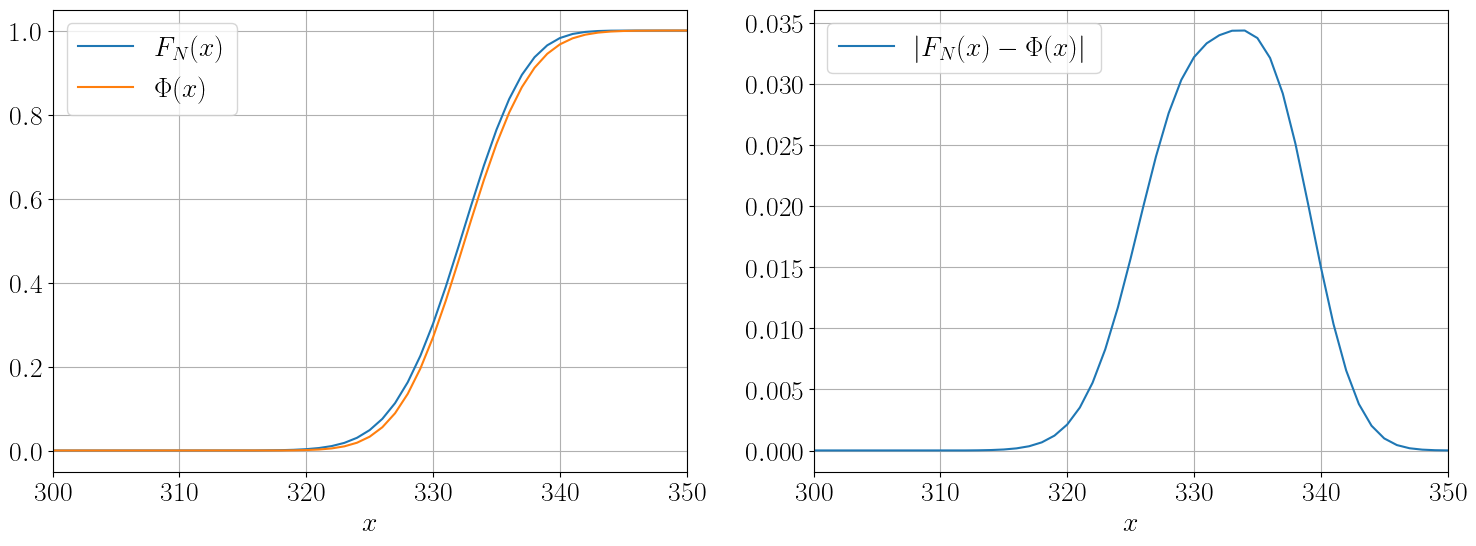

In [15]:
fig, (ax1, ax2) = plt.subplots( 1, 2 )
plt.subplot(121)
plt.plot( k_vec, F_N, label='$F_N(x)$')
plt.plot( k_vec, Gaussian_fit, label='$\\Phi(x)$' )
plt.xlim( (300, 350))
plt.xlabel('$x$')
plt.grid(1)
plt.legend()

Delta = np.abs( F_N - Gaussian_fit )
plt.subplot(122)
plt.plot( k_vec, Delta, label='$|F_N(x)-\\Phi(x)|$')
plt.xlim( (300, 350))
plt.xlabel('$x$')
plt.grid(1)
plt.legend()
plt.savefig('Berry_Esseen_CDF_approx.pdf', dpi=300)

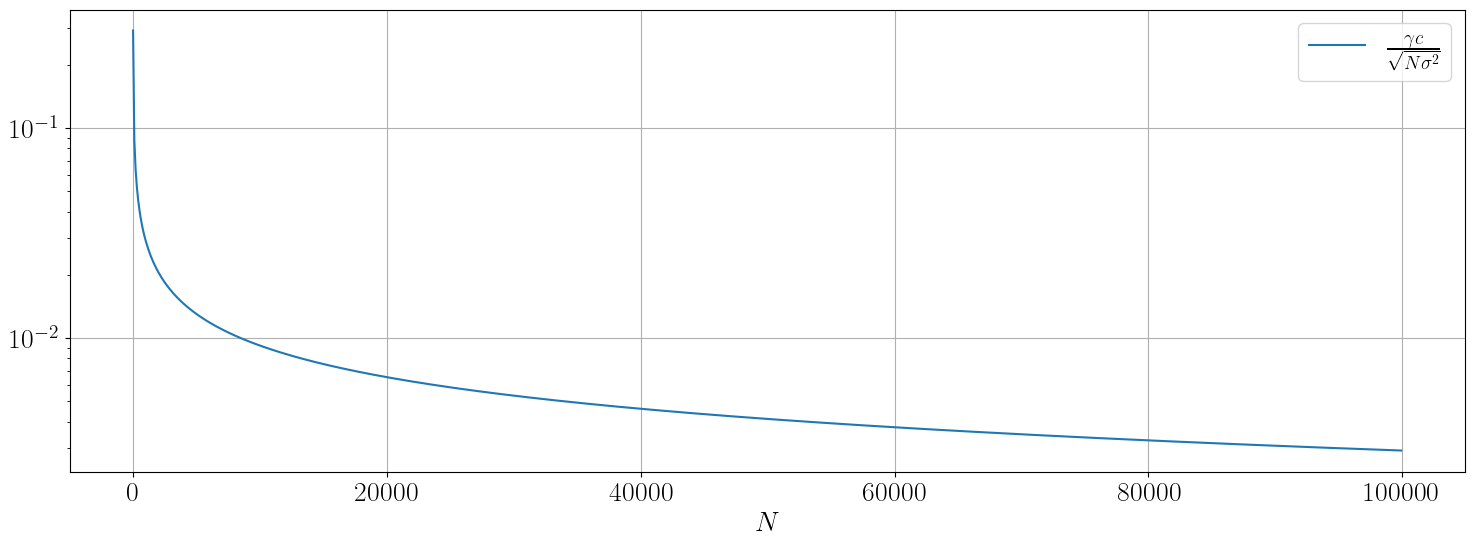

In [14]:
N_values = np.arange( 10, 1e5, 100 )

plt.figure()
plt.semilogy( N_values, const_frac * c / np.sqrt( N_values * sigma2 ), label='$\\frac{\\gamma c}{\\sqrt{N \\sigma^2}}$' )
plt.legend()
plt.xlabel('$N$')
plt.grid(1)
plt.savefig('Berry_Esseen_Bound.pdf', dpi=300)